In [1]:
import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

%matplotlib inline

To introduce Support Vector Machines we'll start with the simplest example: <font color='green'>**linear support vector binary classifiers**</font>. This modeling technique will provide decent performance as well as a solid gateway into more advanced SVM techniques.

Let's look at some data that we might want to classify. Imagine you've got some data from a course about test scores, project scores, and whether the student passed or failed the course.

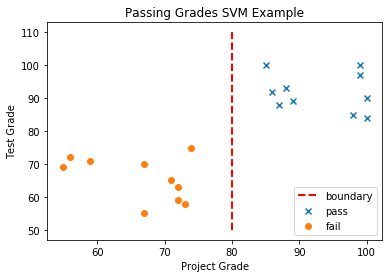

In [2]:
# Example data.
test_data = pd.DataFrame()

test_data['test'] = [90, 100, 85, 93, 88, 100, 97, 92, 89, 84,
                     55, 65, 75, 58, 69, 71, 72, 63, 70, 59]
test_data['project'] = [100, 85, 98, 88, 87, 99, 99, 86, 89, 100,
                        67, 71, 74, 73, 55, 59, 56, 72, 67, 72]
test_data['pass'] = ['pass', 'pass', 'pass', 'pass', 'pass',
                     'pass', 'pass', 'pass', 'pass', 'pass',
                     'fail', 'fail', 'fail', 'fail', 'fail',
                     'fail', 'fail', 'fail', 'fail', 'fail']

# Reusable function to plot our data.
def setup_plot():
    plt.scatter(test_data.project[0:10], test_data.test[0:10], marker='x')
    plt.scatter(test_data.project[10:20], test_data.test[10:20], marker='o')

    # We'll eyeball a pass / fail line to split the points.
    plt.plot([80, 80], [50, 110], 'r--', lw=2)

    plt.xlabel('Project Grade')
    plt.ylabel('Test Grade')

setup_plot()
plt.legend(['boundary', 'pass', 'fail'], loc=4)
plt.title('Passing Grades SVM Example')
plt.show()
    

> In the plot above we eyeballed a straight line decision **boundary** between the pass and fail data points. But is this the _best possible_ boundary line for making predictions? Here are some other options.

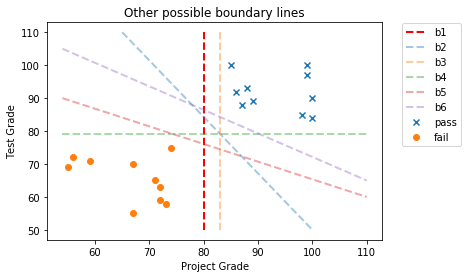

In [3]:
# Throw some other possible boundary lines into the mix.

# Rebuild the previous plot.
setup_plot()

# Add some new boundary lines.
plt.plot([65, 100], [110, 50], '--', lw=2, alpha=0.4)
plt.plot([83, 83], [110, 50], '--', lw=2, alpha=0.4)
plt.plot([54, 110], [79, 79], '--', lw=2, alpha=0.4)
plt.plot([54, 110], [90, 60], '--', lw=2, alpha=0.4)
plt.plot([54, 110], [105, 65], '--', lw=2, alpha=0.4)

plt.legend(['b1', 'b2', 'b3', 'b4', 'b5', 'b6', 'pass', 'fail'],
            bbox_to_anchor=(0.25, 0.02, 1, 1))
plt.title('Other possible boundary lines')
plt.show()

> Are any of these new boundary lines better than our first attempt? Which color looks best to you? Why?

## Margin and Support Vectors

You probably have an intuition that a boundary line passing close to data points is bad because it'll be susceptable to noise and be worse at predicting new data points than a boundary line farther away. In SVM we formalize that intuition by defining the **margin** as the distance between the nearest point of each class and the boundary.

Finding the margin for our initial red boundary line is easy. The nearest point for each class is at (85,100) and (74,75). These nearest points are the **support vectors** that our model is named after. The distance from our support vectors to the red boundary line is just the horizontal distance (because our boundary happens to be vertical). The margin is 5 from the pass support vector and 6 from the fail support vector.

Is that the best we can do? No. Several of the other boundary lines are worse, like the orange boundary line `b3`, but looking at the light blue boundary line `b2` above you can probably see without having to do the math that the margin is larger so it's a _better_ boundary than our initial red boundary. The goal of SVM is find the _best_ boundary, or the boundary that optimizes the margin.


## Finding the optimal boundary

Let's fire it up, using SKLearn to find the actual optimal boundary line. We're doing a linear SVM example, so we'll force the boundary to be linear. To do this we'll use SVC with a linear kernel. We'll get into what that is and other options later. The "C" in `SVC` here stands for "classifier".

In [4]:
from sklearn.svm import SVC

# Instantiate our model and fit the data.
X = test_data[['test', 'project']]
Y = test_data['pass']
svm = SVC(kernel = 'linear')
svm.fit(X, Y)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

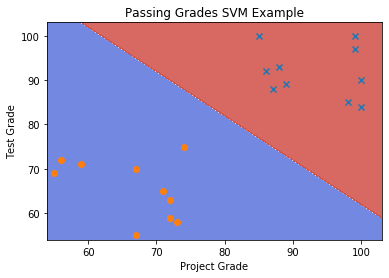

In [5]:
# Visualize our model
y_min, y_max = X.test.min() - 1, X.test.max() + 3
x_min, x_max = X.project.min() - 1, X.project.max() + 3
xx, yy = np.meshgrid(np.arange(x_min, x_max, .1),
                     np.arange(y_min, y_max, .1))

Z = (svm.predict(np.c_[xx.ravel(), yy.ravel()])=='pass')

Z = Z.reshape(xx.shape)
plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(test_data.project[0:10], test_data.test[0:10], marker='x')
plt.scatter(test_data.project[10:20], test_data.test[10:20], marker='o')
plt.xlim(x_min, x_max)
plt.ylim(y_min, y_max)
plt.xlabel('Project Grade')
plt.ylabel('Test Grade')
plt.title('Passing Grades SVM Example')
plt.show()

> That looks pretty much as we'd expect. We can see a nice clear division between the two classes with a maximum distance between the support vectors and the decision boundary. High five ✋

## Things Get Messy

Now this is a nice example, but there are several things about it that are far simpler than anything you're likely to run into in the wild.

This dataset is in two dimensions, but SVM works in as many dimensions as you'd like (given the limitations of your computing resources). The boundary between two groups is therefore not always a line. A line is simply the way to represent this boundary in two dimensions. In general terms, the boundary is always a "hyperplane".

![Not actually a hyperplane](assets/hyperdrive.jpg)

No, that's hyper_drive_.

A **hyperplane** in n-dimensional space is _an n-minus-one-dimensional space_. So for a 2-dimensional plane like this one, a hyperplane is a 1-dimesional line. In 3-dimensional space the hyperplane is a 2-dimensional plane. In 4-dimensional spacetime a hyperplane is a 3-dimensional space. It gets tricky to visualize from here, but the concept continues in any number of dimensions.

Also of note is that this dataset has a boundary that groups each observation exclusively on one side of the line. This is called a _hard margin_. It won't always be possible to make a boundary with a hard margin, however. When it's not, the problem is called _soft margin_ (these two terms apply to all classifiers, by the way).

To deal with this kind of problem, SVM imposes a cost function. The cost function gives SVM two things to balance: the size of the margin (which it wants to maximize) and the cumulative distance of points on the wrong side of the margin from the boundary (which it wants to minimize).

How SVM balances these factors is complex and understanding the vector math behind it is not essential. What _is_ important to know is that you can control the priorities of this tradeoff by controlling that weight. How you'd want to tune it depends on your tolerance for inaccurate results as compared to large margins.

# The kernel trick

So far we’ve talked about SVM with linear boundaries. We put together an example in the previous assignment. Our boundary was a line with a given slope and intercept, a pretty simple thing to visualize. However, a straight line doesn't always nicely classify our data.

In this assignment we’ll show you that we can create non-linear decision boundaries by transforming our data into a higher dimension, finding a good hyperplane boundary in the higher dimension, and transforming the result back to our starting data. We'll also quickly cover the "kernel trick" that SVM uses to _actually_ find our boundary hyperplane in an efficient way that would otherwise be computationally prohibitive using that brute force solution.

Note: this assignment includes interactive 3d plots. Take a moment now to restart the kernel and run all cells.

## Thinking outside the plane

Let's say you have some data that looks like this:

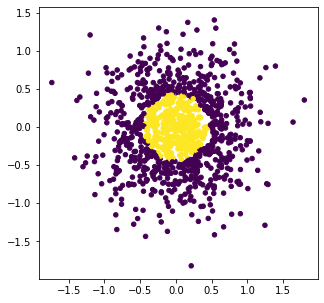

In [6]:
data = pd.DataFrame()
data['x'] = np.random.normal(0, .5, 1000)
data['y'] = np.random.normal(0, .5, 1000)

# Create your circle of indicators
data['d'] = data.x**2 + (data.y)**2 < .2

plt.figure(figsize=(5,5))
plt.scatter(data['x'], data['y'], c=data['d'], s=20)
plt.show()

+ Clearly no straight line boundary is going to do a good job here. What you _really_ want is a circular boundary. Is there any way to do that with a hyperplane? Yes. You just need a little perspective. Let's transform our data from two dimensions into three dimensions by adding a new feature. Specifically, let's add the new feature $x^2 + y^2$.


+  A hyperplane of this new three-dimensional space is just a regular old two-dimensional plane. Let's also slip one in right between our classes.

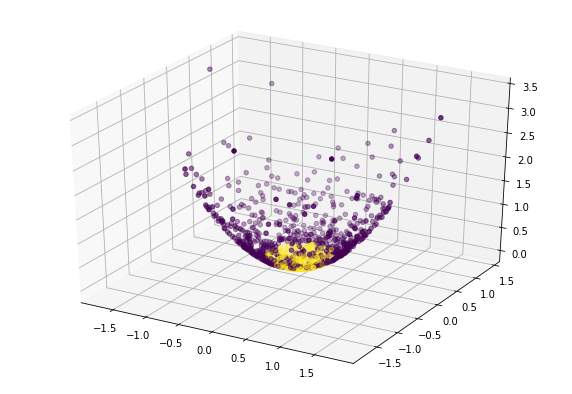

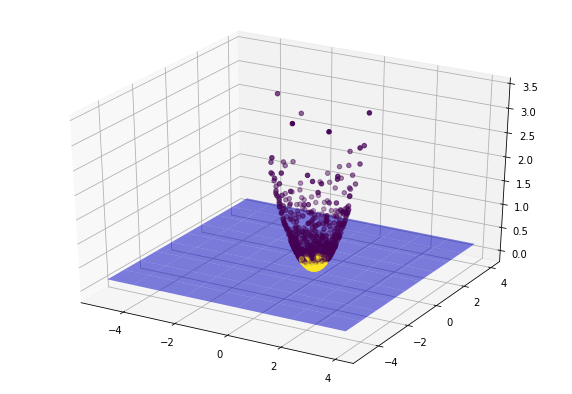

In [7]:
# We're doing some 3D plotting now. 
# Tinker with it if you like but python is generally not great at this kind of thing...

from mpl_toolkits.mplot3d import Axes3D

# Make our new variable
data['x2_y2'] = data.x**2 + data.y**2

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs=data.x, ys=data.y, zs=data.x2_y2, zdir='z', c=data.d)
plt.show()

fig = plt.figure(figsize=(10,7))
ax = fig.add_subplot(111, projection='3d')
xx, yy = np.meshgrid(range(-5, 5, 1), range(-5, 5, 1))
zz = np.empty((10,10))
zz.fill(0.2)
ax.plot_surface(xx, yy, zz, color='b', alpha=.5)
ax.scatter(xs=data.x, ys=data.y, zs=data.x2_y2, zdir='z', c=data.d)

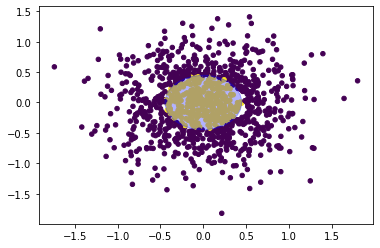

In [8]:
circle1 = plt.Circle((0, 0), np.sqrt(.2), color='b', alpha=.3)

fig, ax = plt.subplots()

ax.scatter(data['x'], data['y'], c=data['d'], s= 20)
ax.add_artist(circle1)
plt.show()

# Guided example and challenge
Now it's time for another guided example. This time we're going to look at recipes. Specifically we'll use the epicurious dataset, which has a collection of recipes, key terms and ingredients, and their ratings.

What we want to see is if we can use the ingredient and keyword list to predict the rating. For someone writing a cookbook this could be really useful information that could help them choose which recipes to include because they're more likely to be enjoyed and therefore make the book more likely to be successful.

First let's load the dataset. It's [available on Kaggle](https://www.kaggle.com/hugodarwood/epirecipes). We'll use the csv file here and as pull out column names and some summary statistics for ratings.

In [18]:
raw_data = pd.read_csv('https://tf-assets-prod.s3.amazonaws.com/tf-curric/data-science/epi_r.csv')

In [10]:
list(raw_data.columns)

['title',
 'rating',
 'calories',
 'protein',
 'fat',
 'sodium',
 '#cakeweek',
 '#wasteless',
 '22-minute meals',
 '3-ingredient recipes',
 '30 days of groceries',
 'advance prep required',
 'alabama',
 'alaska',
 'alcoholic',
 'almond',
 'amaretto',
 'anchovy',
 'anise',
 'anniversary',
 'anthony bourdain',
 'aperitif',
 'appetizer',
 'apple',
 'apple juice',
 'apricot',
 'arizona',
 'artichoke',
 'arugula',
 'asian pear',
 'asparagus',
 'aspen',
 'atlanta',
 'australia',
 'avocado',
 'back to school',
 'backyard bbq',
 'bacon',
 'bake',
 'banana',
 'barley',
 'basil',
 'bass',
 'bastille day',
 'bean',
 'beef',
 'beef rib',
 'beef shank',
 'beef tenderloin',
 'beer',
 'beet',
 'bell pepper',
 'berry',
 'beverly hills',
 'birthday',
 'biscuit',
 'bitters',
 'blackberry',
 'blender',
 'blue cheese',
 'blueberry',
 'boil',
 'bok choy',
 'bon appétit',
 'bon app��tit',
 'boston',
 'bourbon',
 'braise',
 'bran',
 'brandy',
 'bread',
 'breadcrumbs',
 'breakfast',
 'brie',
 'brine',
 'brisk

In [11]:
raw_data.rating.describe()

count    20052.000000
mean         3.714467
std          1.340829
min          0.000000
25%          3.750000
50%          4.375000
75%          4.375000
max          5.000000
Name: rating, dtype: float64

> We learn a few things from this analysis. From a ratings perspective, there are just over 20,000 recipes with an average rating of 3.71. What is interesting is that the 25th percentile is actually above the mean. This means there is likely some kind of outlier population. This makes sense when we think about reviews: some bad recipes may have very few very low reviews.

Let's validate the idea a bit further with a histogram.

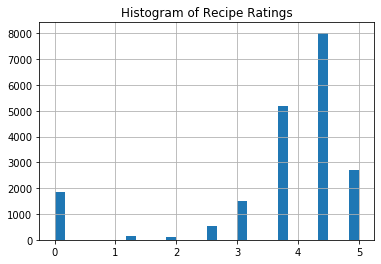

In [12]:
raw_data.rating.hist(bins=30)
plt.title('Histogram of Recipe Ratings')
plt.show()

> So a few things are shown in this histogram. Firstly there are sharp discontinutities. We don't have continuous data. No recipe has a 3.5 rating, for example. Also we see the anticipated increase at 0.

Let's try a naive approach again, this time using SVM Regressor. But first, we'll have to do a bit of data cleaning.

In [13]:
# Count nulls 
null_count = raw_data.isnull().sum()
null_count[null_count>0]

calories    4117
protein     4162
fat         4183
sodium      4119
dtype: int64

> What we can see right away is that nutrition information is not available for all goods. Now this would be an interesting data point, but let's focus on ingredients and keywords right now. So we'll actually drop the whole columns for calories, protein, fat, and sodium. We'll come back to nutrition information later.

In [24]:
from sklearn.svm import SVR

svr = SVR()
X = raw_data.drop(['rating', 'title', 'calories', 'protein', 'fat', 'sodium'], 1).sample(frac=0.3, replace=True, random_state=1)
Y = raw_data.rating.sample(frac=0.3, replace=True, random_state=1)
%time svr.fit(X,Y)

/home/uzi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


CPU times: user 29.2 s, sys: 15.9 ms, total: 29.2 s
Wall time: 29.3 s


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1,
    gamma='auto_deprecated', kernel='rbf', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

> __Note that this actually takes quite a while to run, compared to some of the models we've done before. Be patient.__ It's because of the number of features we have.

Let's see what a scatter plot looks like, comparing actuals to predicted.

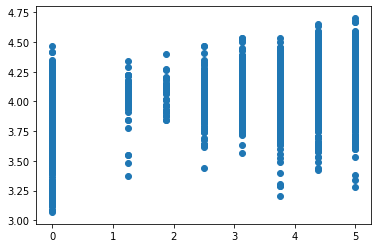

In [15]:
plt.scatter(Y, svr.predict(X))

> Now that is a pretty useless visualization. This is because of the discontinuous nature of our outcome variable. There's too much data for us to really see what's going on here. If you wanted to look at it you could create histograms, here we'll move on to the scores of both our full fit model and with cross validation. Again if you choose to run it again it will take some time, so you probably shouldn't.

In [26]:
%time svr.score(X, Y)

CPU times: user 28.9 s, sys: 7.84 ms, total: 28.9 s
Wall time: 28.9 s


-0.003978314483867651

In [27]:
from sklearn.model_selection import cross_val_score
%time cross_val_score(svr, X, Y, cv=5)

/home/uzi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/uzi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/uzi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/home/uzi/anaconda3/lib/python3.7/site-packages/sklearn/svm/base

CPU times: user 1min 57s, sys: 3.94 ms, total: 1min 57s
Wall time: 1min 57s


array([-0.01787926, -0.02916288, -0.02841122, -0.03767394, -0.01735362])

Oh dear, so this did seem not to work very well. In fact it is remarkably poor. Now there are many things that we could do here. 

Firstly the overfit is a problem, even though it was poor in the first place. We could go back and clean up our feature set. There might be some gains to be made by getting rid of the noise.

We could also see how removing the nulls but including dietary information performs. Though its a slight change to the question we could still possibly get some improvements there.

Lastly, we could take our regression problem and turn it into a classifier. With this number of features and a discontinuous outcome, we might have better luck thinking of this as a classification problem. We could make it simpler still by instead of classifying on each possible value, group reviews to some decided high and low values.

# __And that is your challenge.__

Transform this regression problem into a binary classifier and clean up the feature set. You can choose whether or not to include nutritional information, but try to cut your feature set down to the 30 most valuable features.

Good luck!

In [29]:
from sklearn.svm import SVC
svc = SVC()

# Turn our target into a binary class
raw_data['high_rating'] = raw_data['rating'] >= 4
raw_data.high_rating.head()

0    False
1     True
2    False
3     True
4    False
Name: high_rating, dtype: bool

In [39]:
corrs = raw_data.corr()['high_rating']
features = {}
for i, value in enumerate(corrs):
    # I chose 0.035 somewhat arbitrarily after looking at the correlation values bc it grabs 31 values
    if np.abs(value) >= 0.035 and corrs.index[i] not in ['rating', 'high_rating']:
        print(corrs.index[i] + ' ' + str(value))
        features.update( {corrs.index[i] : round(value, 3)} )

alcoholic -0.07715823998378549
backyard bbq 0.0476818814092915
bitters -0.052950993337664225
bon appétit 0.09707613086634137
christmas 0.05440880286514592
cocktail -0.04582923731224577
cocktail party -0.06353425376827555
dessert 0.03622484083543544
dinner 0.06218595641137865
drink -0.08306502540127653
fall 0.046564688610337246
father's day 0.03656436606548068
gin -0.07106578913172494
goat cheese 0.04120721628747022
grill 0.042924173866381456
grill/barbecue 0.05120386185809113
harpercollins -0.04234451978149444
house & garden -0.09280136285503131
low fat -0.04922959628651984
meat 0.0358013340207821
pasta -0.04309165595709404
peanut free 0.06589686366845558
roast 0.06819760679983776
rum -0.04179206568765611
soy free 0.06579930567325504
spirit -0.05702848550292039
stir-fry -0.03833618612408754
stuffing/dressing 0.04245369160377869
thanksgiving 0.06709422617839009
tree nut free 0.04794332938530719
vegan -0.03945818739751613


In [37]:
features

['alcoholic',
 'backyard bbq',
 'bitters',
 'bon appétit',
 'christmas',
 'cocktail',
 'cocktail party',
 'dessert',
 'dinner',
 'drink',
 'fall',
 "father's day",
 'gin',
 'goat cheese',
 'grill',
 'grill/barbecue',
 'harpercollins',
 'house & garden',
 'low fat',
 'meat',
 'pasta',
 'peanut free',
 'roast',
 'rum',
 'soy free',
 'spirit',
 'stir-fry',
 'stuffing/dressing',
 'thanksgiving',
 'tree nut free',
 'vegan']

In [40]:
# Hide the warnings
warnings.filterwarnings('ignore')

cross_val_score(svc, raw_data[features], raw_data['high_rating'], cv=5)

array([0.56045874, 0.57317377, 0.57417103, 0.57506234, 0.57919681])